<a href="https://colab.research.google.com/github/nsmancini/odsc_stuff/blob/main/bda_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Decision Analysis

Allen Downey

[Bayesian Decision Analysis](https://allendowney.github.io/BayesianDecisionAnalysis/)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## The Bayesian bandit problem

Suppose you have several "one-armed bandit" slot machines, and there's reason to think that they have different probabilities of paying off.

Each time you play a machine, you either win or lose, and you can use the outcome to update your belief about the probability of winning.

Then, to decide which machine to play next, you can use the "Bayesian bandit" strategy, explained below.

First, let's see how to do the update.

## The prior

If we know nothing about the probability of winning, we can start with a uniform prior.

In [6]:
xs = np.arange(101)
p = 1/len(xs)
prior = pd.Series(p, index=xs)
prior.head()

0    0.009901
1    0.009901
2    0.009901
3    0.009901
4    0.009901
dtype: float64

In [7]:
def decorate(title=""):
    """Labels the axes.

    title: string
    """
    plt.xlabel("Probability of winning")
    plt.ylabel("PMF")
    plt.title(title)

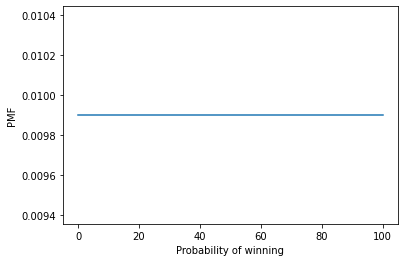

In [9]:
prior.plot()
decorate()

## Bayesian Update

Suppose that prior represents what we believe about possible values of `x` before we have any data.
Now suppose we play a machine once and win.
What should we believe about `x` now?

We can answer that question by computing the likelihood of the data, a win, for each value of `x`.
If `x` is 50, the probability of winning is 0.5.
If `x` is 75, the probability is 0.75.
In general, we can compute the probabilities by dividing the values of `x` by 100.

In [10]:
likelihood_win = xs/100

In [11]:
posterior = prior * likelihood_win
posterior.head()

0    0.000000
1    0.000099
2    0.000198
3    0.000297
4    0.000396
dtype: float64

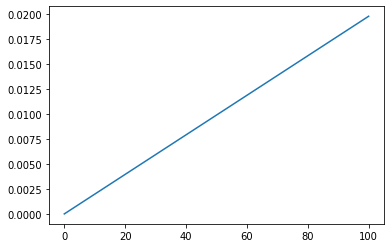

In [12]:
posterior/=posterior.sum()
posterior.plot()

In [ ]:
posterior.plot()
decorate("Posterior, one win")

Suppose we play the same machine and win again. We can do a second update, using the posterior from the first update as the prior for the second.

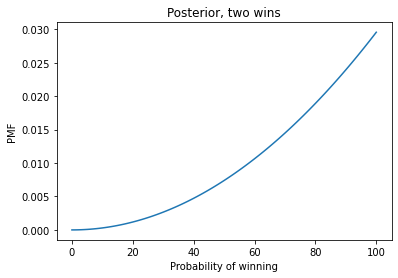

In [13]:
posterior2 = posterior * likelihood_win
posterior2 /= posterior2.sum()
posterior2.plot()
decorate("Posterior, two wins")

And suppose we play one more time and lose. Now we need the likelihood of losing for each value of `x`.


In [14]:
likelihood_loss = 1 - xs/100

And here's the update.

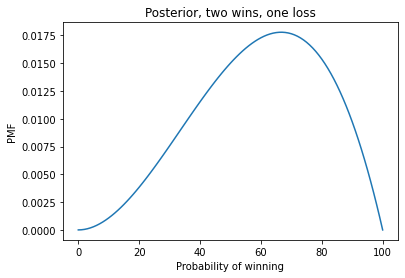

In [15]:
posterior3 = posterior2 * likelihood_loss
posterior3 /= posterior3.sum()
posterior3.plot()
decorate("Posterior, two wins, one loss")

## The update function

The following function takes as parameters a Pandas Series that represents the prior distribution and a string that represents the data: either `W` if we won or `L` if we lost.

In [16]:
def update(pmf, data):
    """Likelihood function for Bayesian bandit

    pmf: Series that maps hypotheses to probabilities
    data: string, either 'W' or 'L'
    """
    if data == "W":
        likelihood = likelihood_win
    else:
        likelihood = likelihood_loss

    pmf *= likelihood
    pmf /= pmf.sum()

It uses the quantities in the index to compute the likelihood of the data, then updates `pmf` by multiplying by the likelihood and dividing through by the probability of the data.

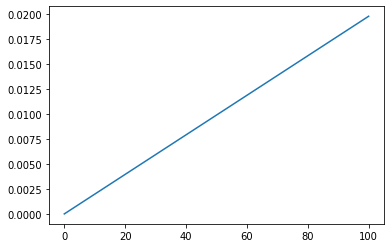

In [17]:
pmf = prior.copy()
update(pmf,'W')
pmf.plot()

### Exercise

Suppose you play a machine 10 times and win once.  What is the posterior distribution of $x$?

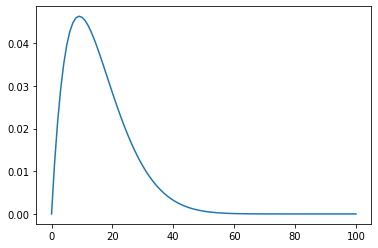

In [25]:
pmf = prior.copy()
for i in range(0,10):
  if i == 2:
    update(pmf,'W')
  update(pmf,'L')
pmf.plot()

## Multiple bandits

Now suppose we have several bandits and we want to decide which one to play.

For this example, suppose we have 4 machines with these probabilities:

In [27]:
actual_probs = [0.0, 0.1, 0.2, 0.3]

For purposes of the example, we should assume that we do not know these probabilities.

The function `play` simulates playing one machine once and returns `W` or `L`.

In [28]:
from random import random


def flip(p):
    """Return True with probability p."""
    return random() < p

In [29]:
from collections import Counter

# count how many times we've played each machine
counter = Counter()


def play(i):
    """Play machine i.

    returns: string 'W' or 'L'
    """
    counter[i] += 1
    p = actual_probs[i]
    if flip(p):
        return "W"
    else:
        return "L"

Here's a test, playing machine 3 ten times:

In [30]:
for i in range(10):
    outcome = play(3)
    print(outcome, end=" ")

W W W W L L L L W W 

Now I'll make four copies of the prior to represent our beliefs about the four machines.

In [36]:
beliefs = [prior.copy() for i in range(4)]
beliefs

[0      0.009901
 1      0.009901
 2      0.009901
 3      0.009901
 4      0.009901
          ...   
 96     0.009901
 97     0.009901
 98     0.009901
 99     0.009901
 100    0.009901
 Length: 101, dtype: float64, 0      0.009901
 1      0.009901
 2      0.009901
 3      0.009901
 4      0.009901
          ...   
 96     0.009901
 97     0.009901
 98     0.009901
 99     0.009901
 100    0.009901
 Length: 101, dtype: float64, 0      0.009901
 1      0.009901
 2      0.009901
 3      0.009901
 4      0.009901
          ...   
 96     0.009901
 97     0.009901
 98     0.009901
 99     0.009901
 100    0.009901
 Length: 101, dtype: float64, 0      0.009901
 1      0.009901
 2      0.009901
 3      0.009901
 4      0.009901
          ...   
 96     0.009901
 97     0.009901
 98     0.009901
 99     0.009901
 100    0.009901
 Length: 101, dtype: float64]

This function displays four distributions in a grid.

In [32]:
def plot(beliefs, **options):
    for i, b in enumerate(beliefs):
        plt.subplot(2, 2, i + 1)
        b.plot(label="Machine %s" % i)
        plt.gca().set_yticklabels([])
        plt.legend()

    plt.tight_layout()

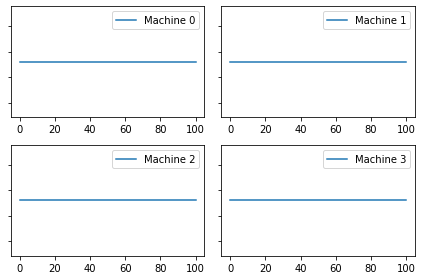

In [37]:
plot(beliefs)

As an example, let's play each machine 10 times, then plot the posterior distributions.  

In [38]:
for i in range(4):
  for _ in range(10):
    outcome = play(i)
    update(beliefs[i], outcome)

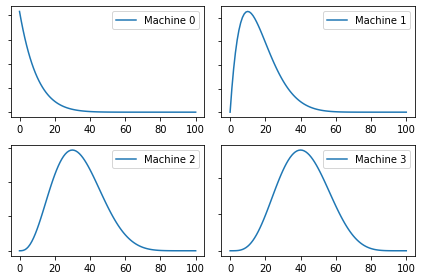

In [39]:
plot(beliefs)

## Bayesian Bandits

To get more information, we could play each machine 100 times, but while we are gathering data, we are not making good use of it.  The kernel of the Bayesian Bandits algorithm is that it collects and uses data at the same time.  In other words, it balances exploration and exploitation.

To do that, it draws a random value from each distribution and chooses the the machine that generates the largest value.

The following function takes a PMF and chooses a random value from it, using the probabilities as weights.

In [40]:
def pmf_choice(pmf):
    """Draw a random sample from a PMF.

    pmf: Series representing a PMF

    returns: quantity from PMF
    """
    return np.random.choice(a=pmf.index, p=pmf.values)

Here's an example.

In [41]:
pmf_choice(beliefs[0])

7

The following function uses `pmf_choice` to choose one value from the posterior distribution of each machine and then uses `argmax` to find the index of the machine that chose the highest value.

In [42]:
def choose(beliefs):
    """Use the Bayesian bandit strategy to choose a machine.

    Draws a sample from each distribution.

    returns: index of the machine that yielded the highest value
    """
    ps = [pmf_choice(b) for b in beliefs]
    return np.argmax(ps)

Here's an example.

In [58]:
choose(beliefs)

3

`choose` has the property that the probability of choosing each machine is equal to its "probability of superiority".

**Exercise 3:** Putting it all together, fill in the following function to choose a machine, play once, and update `beliefs`:

In [61]:
def choose_play_update(beliefs, verbose=False):
    """Chose a machine, play it, and update beliefs.

    beliefs: list of Pmf objects
    verbose: Boolean, whether to print results
    """
    # choose a machine
    machine = choose(beliefs)

    # play it
    outcome = play(machine)

    # update beliefs
    update(beliefs[machine],outcome)

    if verbose:
        print(machine, outcome)

Here's an example:

In [75]:
choose_play_update(beliefs, verbose=True)

3 L


In [76]:
counter

Counter({0: 20, 1: 20, 2: 22, 3: 42})

## Trying it out

Let's start again with a fresh set of machines and an empty `Counter`.

In [79]:
beliefs = [prior.copy() for i in range(4)]
counter = Counter()

If we run the bandit algorithm 100 times, we can see how `beliefs` gets updated:

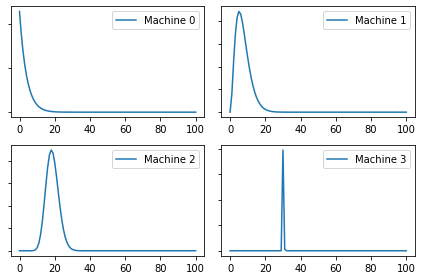

In [93]:
num_plays = 10000

for i in range(num_plays):
    choose_play_update(beliefs)

plot(beliefs)

The estimates are still rough, especially for the lower-probability machines.  But that's a feature, not a bug: the goal is to play the high-probability machines most often.  Making the estimates more precise is a means to that end, but not an end itself.

Let's see how many times each machine got played.  If things go according to plan, the machines with higher probabilities should get played more often.

In [94]:
for machine, count in sorted(counter.items()):
    print(machine, count)

0 25
1 39
2 116
3 25220


**Exercise 4:**  Go back and run this section again with a different value of `num_play` and see how it does.

## Summary

The algorithm I presented in this notebook is called [Thompson sampling](https://en.wikipedia.org/wiki/Thompson_sampling).  It is an example of a general strategy called [Bayesian decision theory](https://wiki.lesswrong.com/wiki/Bayesian_decision_theory), which is the idea of using a posterior distribution as part of a decision-making process, usually by choosing an action that minimizes the costs we expect on average (or maximizes a benefit).

In my opinion, this strategy is the biggest advantage of Bayesian methods over classical statistics.  When we represent knowledge in the form of probability distributions, Bayes's theorem tells us how to change our beliefs as we get more data, and Bayesian decision theory tells us how to make that knowledge actionable.

Copyright 2022 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)